# Conjugate Priors v.s. Sampling

In this notebook, we compare two methods for computing posterior distributions in Bayesian inference. 

1. Using **conjugate priors** to obtain closed-form, analytic posterior distributions.
2. Using **Metropolis-Hastings MCMC** to draw samples from the posterior distribution.

We will also provide a scaffold for implementing a **Gibbs sampler**.


> A **conjugate prior** is a prior distribution that, when combined with a specific likelihood, results in a posterior distribution from the same distribution family as the prior. 

A list of common conjugate pairs can be found [here](https://en.wikipedia.org/wiki/Conjugate_prior).

### 1. Data Generation


We simulate $n = 100$ observations from a normal distribution with true parameters $\mu = 2$ and  $\sigma = 1$. In this notebook, we will treat both $\mu$ and $\sigma^2$ as unknown parameters. 



In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Set seed for reproducibility
np.random.seed(42)

# Parameters
mu_true = 2
sigma_true = 1
n = 100

# Generate data
x = np.random.normal(loc=mu_true, scale=sigma_true, size=n)


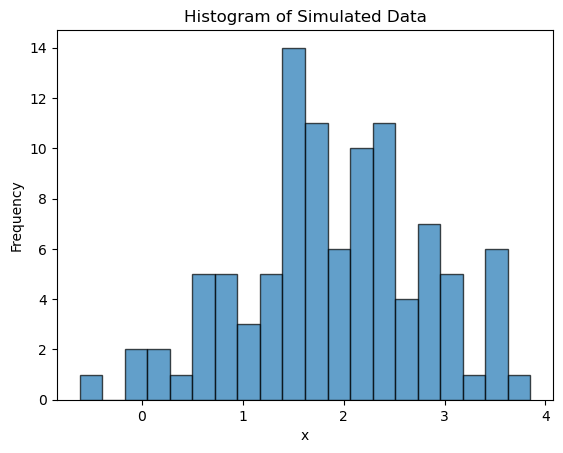

In [7]:
# Optional: Plot the histogram of the generated data

plt.hist(x, bins=20, edgecolor='k', alpha=0.7)
plt.title("Histogram of Simulated Data")
plt.xlabel("x")
plt.ylabel("Frequency")
plt.show()

### 2. Conjugate Prior


When both $\mu$ and $ \sigma^2 $ are unknown, the conjugate prior for normal likelihoods is the **Normal-Inverse-Gamma** distribution:
$$\sigma^2 \sim \text{Inv-Gamma}(\alpha_0, \beta_0), \quad \mu \mid \sigma^2 \sim \mathcal{N}(\mu_0, \sigma^2 / \kappa_0).$$

The posterior distribution is 
$$\mu \mid \sigma^2, x \sim \mathcal{N}(\mu_n, \sigma^2 / \kappa_n), \quad \sigma^2 \mid x \sim 	\text{Inv-Gamma}(\alpha_n, \beta_n),$$
where
$$\kappa_n = \kappa_0 + n, \quad
\mu_n = \frac{\kappa_0 \mu_0 + n {\rm var}(x)}{\kappa_n}$$
$$\alpha_n = \alpha_0 + \frac{n}{2}, \quad \eta_n = \beta_0 + \frac{1}{2} \sum \{x_i - {\rm var}(x)\}^2 + \frac{\kappa_0 n \{ {\rm var}(x) - \mu_0\}^2}{2 \kappa_n}$$

Here $\mu_0, \kappa_0, \alpha_0, \beta_0$ are the *hyperparameters*. We choose $\mu_0=0$, $\kappa_0=1$, $\alpha_0=2$ and $\beta_0=2$ in this analysis. 

Posterior mean (mu): 1.876, MAP: 1.877
Posterior mean (sigma^2): 0.873, MAP: 0.842


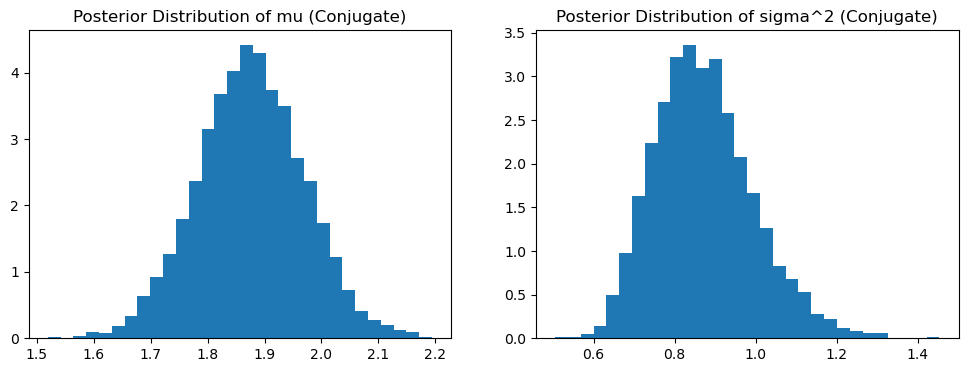

In [ ]:

# Hyperparameters
mu0 = 0
kappa0 = 1
alpha0 = 2
beta0 = 2

# Statistics
xbar = np.mean(x)
S = np.sum((x - xbar)**2)

# Posterior parameters
kappan = kappa0 + n
mun = (kappa0 * mu0 + n * xbar) / kappan
alphan = alpha0 + n / 2
betan = beta0 + 0.5 * S + (kappa0 * n * (xbar - mu0)**2) / (2 * kappan)

# Posterior draws
num_draws = 5000
sigma2_draws = stats.invgamma.rvs(a=alphan, scale=betan, size=num_draws)
mu_draws = stats.norm.rvs(loc=mun, scale=np.sqrt(sigma2_draws / kappan))

# Posterior mean and MAP
mu_mean_conj = np.mean(mu_draws)
mu_map_conj = mu_draws[np.argmax(stats.norm.pdf(mu_draws, mun, np.sqrt(sigma2_draws / kappan)))]

sigma2_mean_conj = np.mean(sigma2_draws)
sigma2_map_conj = sigma2_draws[np.argmax(stats.invgamma.pdf(sigma2_draws, alphan, scale=betan))]

print(f"Posterior mean (mu): {mu_mean_conj:.3f}, MAP: {mu_map_conj:.3f}")
print(f"Posterior mean (sigma^2): {sigma2_mean_conj:.3f}, MAP: {sigma2_map_conj:.3f}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(mu_draws, bins=30, density=True)
plt.title("Posterior Distribution of mu (Conjugate)")
plt.subplot(1, 2, 2)
plt.hist(sigma2_draws, bins=30, density=True)
plt.title("Posterior Distribution of sigma^2 (Conjugate)")
plt.show()


### 3. Posterior Sampling with Metropolis-Hastings


We now approximate the posterior distribution using the **Metropolis-Hastings (MH)** algorithm. Roughly speaking, to draw a new sample from the posterior, the MH algorithm generate a new candidate using a *proposal distribution*, and then it evaluate the acceptance rate based on the new location in the parameter space and the starting location. A detailed breakdown using this analysis as an example is provided below. 



We want to draw a new sample from the posterior distribution
$$
p(\mu, \sigma^2 \mid x) \propto p(x \mid \mu, \sigma^2) \cdot p(\mu \mid \sigma^2) \cdot p(\sigma^2).
$$

Step 1: **Proposal distribution**

We propose new values from 
$$
\mu' \sim \mathcal{N}(\mu^{(t)}, \, 0.5^2), \quad 
\sigma'^2 \sim \left|\mathcal{N}(\sigma^{2(t)}, \, 0.5^2)\right|
$$


Step 2: **Compute acceptance ratio**

$$
r = \frac{p(\mu', \sigma'^2 \mid x)}{p(\mu^{(t)}, \sigma^{2(t)} \mid x)} 
= \exp\left( \log p(\mu', \sigma'^2 \mid x) - \log p(\mu^{(t)}, \sigma^{2(t)} \mid x) \right)
$$
Here the log posteriors take the form 
$$\log p(\mu, \sigma^2 \mid x) = 
- \frac{n}{2} \log(2\pi \sigma^2) - \frac{1}{2\sigma^2} \sum_{i=1}^n (x_i - \mu)^2 \\
+ \log \mathcal{N}(\mu \mid \mu_0, \sigma^2 / \kappa_0) + \log \text{InvGamma}(\sigma^2 \mid \alpha_0, \beta_0)
$$


Step 3: **Accept or reject**

With probability $\min(1, r)$, set:
$$
(\mu^{(t+1)}, \sigma^{2(t+1)}) = (\mu', \sigma'^2)
$$

Otherwise, retain the previous values:
$$
(\mu^{(t+1)}, \sigma^{2(t+1)}) = (\mu^{(t)}, \sigma^{2(t)})
$$



In [9]:

# MCMC sampler using MH
import time

num_samples = 5000
burn_in = 1000
mu_current = 0
sigma2_current = 1
mu_chain = []
sigma2_chain = []

start_time = time.time()

for i in range(num_samples + burn_in):
    # Propose new values
    mu_proposal = np.random.normal(mu_current, 0.5)
    sigma2_proposal = abs(np.random.normal(sigma2_current, 0.5))  # keep positive

    # Compute log posterior
    def log_posterior(mu, sigma2):
        log_like = -0.5 * n * np.log(2 * np.pi * sigma2) - np.sum((x - mu)**2) / (2 * sigma2)
        log_prior = stats.norm.logpdf(mu, mu0, np.sqrt(sigma2 / kappa0)) + stats.invgamma.logpdf(sigma2, alpha0, scale=beta0)
        return log_like + log_prior

    log_p_current = log_posterior(mu_current, sigma2_current)
    log_p_proposal = log_posterior(mu_proposal, sigma2_proposal)

    # Accept/reject
    accept_ratio = np.exp(log_p_proposal - log_p_current)
    if np.random.rand() < accept_ratio:
        mu_current = mu_proposal
        sigma2_current = sigma2_proposal

    if i >= burn_in:
        mu_chain.append(mu_current)
        sigma2_chain.append(sigma2_current)

end_time = time.time()
mcmc_time = end_time - start_time

print(f"Sampling completed in {mcmc_time:.2f} seconds.")


Sampling completed in 0.82 seconds.


We need to draw the sample trajectories to check whether the sampling algorithm has *converged*, meaning that it draws samples around the posterior. 

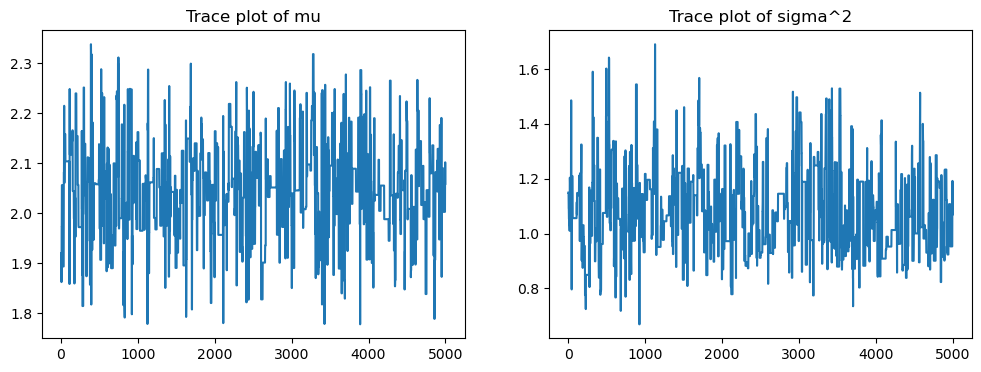

In [4]:

# Diagnostic plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(mu_chain)
plt.title("Trace plot of mu")
plt.subplot(1, 2, 2)
plt.plot(sigma2_chain)
plt.title("Trace plot of sigma^2")
plt.show()


Now we are ready to make inference based on the posterior samples.

Posterior mean (mu): 1.882, MAP: 1.925
Posterior mean (sigma^2): 0.881, MAP: 0.842


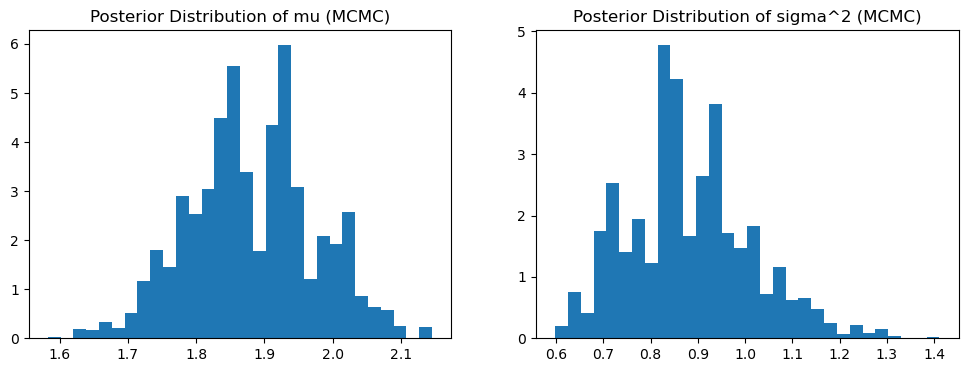

In [10]:

mu_mean_mcmc = np.mean(mu_chain)
mu_map_mcmc = mu_chain[np.argmax(stats.gaussian_kde(mu_chain).evaluate(mu_chain))]

sigma2_mean_mcmc = np.mean(sigma2_chain)
sigma2_map_mcmc = sigma2_chain[np.argmax(stats.gaussian_kde(sigma2_chain).evaluate(sigma2_chain))]

print(f"Posterior mean (mu): {mu_mean_mcmc:.3f}, MAP: {mu_map_mcmc:.3f}")
print(f"Posterior mean (sigma^2): {sigma2_mean_mcmc:.3f}, MAP: {sigma2_map_mcmc:.3f}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(mu_chain, bins=30, density=True)
plt.title("Posterior Distribution of mu (MCMC)")
plt.subplot(1, 2, 2)
plt.hist(sigma2_chain, bins=30, density=True)
plt.title("Posterior Distribution of sigma^2 (MCMC)")
plt.show()


### 4. Gibbs Sampler (Optional)


In Gibbs sampling, we alternately sample from the **conditional posteriors**:
- $\mu \mid \sigma^2, x \sim \mathcal{N}(\mu_n, \sigma^2 / \kappa_n) $
- $ \sigma^2 \mid \mu, x \sim 	\text{Inv-Gamma}(\alpha_n, \beta_n(\mu)) $

Gibbs samplers are particularly helpful in drawing samples from distributions with complex joint posteriors but simple conditional posteriors for each parameter. Below is a scaffold for you to complete.


In [ ]:

# TODO: Implement Gibbs sampler here
num_samples = 5000
mu_samples = []
sigma2_samples = []

# Initialize
mu_gibbs = 0
sigma2_gibbs = 1

for i in range(num_samples):
    # TODO: Sample mu from conditional posterior
    # mu_gibbs = ...

    # TODO: Sample sigma^2 from conditional posterior
    # sigma2_gibbs = ...

    mu_samples.append(mu_gibbs)
    sigma2_samples.append(sigma2_gibbs)
